*UID*:


# **CMSC426 Project 3: From Pixels to 3D Worlds : Two-View 3D Reconstruction**

# **Introduction**

We've spent a lot of time working with images, mostly in 2D scenes. Remember Project 1, where we stitched images together by finding common features between them? Well, now it’s time to take things up a notch! Imagine being able to create a 3D view of a scene using just two images and figuring out exactly where the camera was positioned relative to that scene. Sounds exciting, right?

This approach is actually a simplified version of something called Structure from Motion (SfM). While SfM usually involves reconstructing 3D structures from many images taken from different angles, we’ll start with something more manageable: Two-View Reconstruction. Instead of dealing with a whole collection of viewpoints, we’ll be focusing on building a 3D structure using only two images taken from different perspectives. The key idea? Matching features between these two images to reconstruct the scene in 3D and understand how the camera moved between shots.

* Feature Matching
* Outlier Rejection using RANSAC & Estimating the Fundamental Matrix
*  Estimating the Essential Matrix from the Fundamental Matrix
*  Estimating Camera Pose from the Essential Matrix
* Checking for Cheirality Condition using Triangulation
* Linear Triangulation of Points

Reading Module : https://cmsc733.github.io/2022/proj/p3/

Video Lecture : [link](https://drive.google.com/file/d/1KxBYehdtbVpH4A0vsNwbLpuLsGNqYH8F/view?usp=sharing)

Allowed functions: Any functions regarding reading, writing and displaying/plotting images in cv2, matplotlib

Basic math utitlies including convolution operations in numpy and math



# **Step 1: Feature Matching** [5 points]

In [45]:
# Download data from Google Drive
import gdown
import cv2
import numpy as np
import matplotlib.pyplot as plt
#gdown.download_folder(id="1ROQl0NTBnxMjLrO5qISyxcTCJUPSMsRS", quiet=True, use_cookies=False)

In [46]:
def display_matches(img1, img2, pts1, pts2):
    """
    Visualize the matching points between two images.

    Input:
        img1: Image 1 in numpy array format.
        img2: Image 2 in numpy array format.
        pts1: Matched points in Image 1 (numpy array of shape Nx2).
        pts2: Matched points in Image 2 (numpy array of shape Nx2).
    """
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    new_img = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    new_img[:h1, :w1, :] = img1
    new_img[:h2, w1:w1 + w2, :] = img2

    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(new_img, cv2.COLOR_BGR2RGB))

    for pt1, pt2 in zip(pts1, pts2):
        pt1 = tuple(pt1.astype(int))
        pt2 = (int(pt2[0] + w1), int(pt2[1]))
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'y-', linewidth=1)
        plt.plot(pt1[0], pt1[1], 'ro', markersize=1)
        plt.plot(pt2[0], pt2[1], 'ro', markersize=1)

    plt.axis('off')
    plt.show()

In [47]:
def load_data(image1_path, image2_path,npz_path):
    # Load images
    img1 = cv2.imread(image1_path)
    img2 = cv2.imread(image2_path)

    # Load correspondences
    data = np.load(npz_path)
    pts1 = data['pts1']  # Nx2 array of points in the first image
    pts2 = data['pts2']  # Nx2 array of points in the second image
    return img1, img2,pts1, pts2

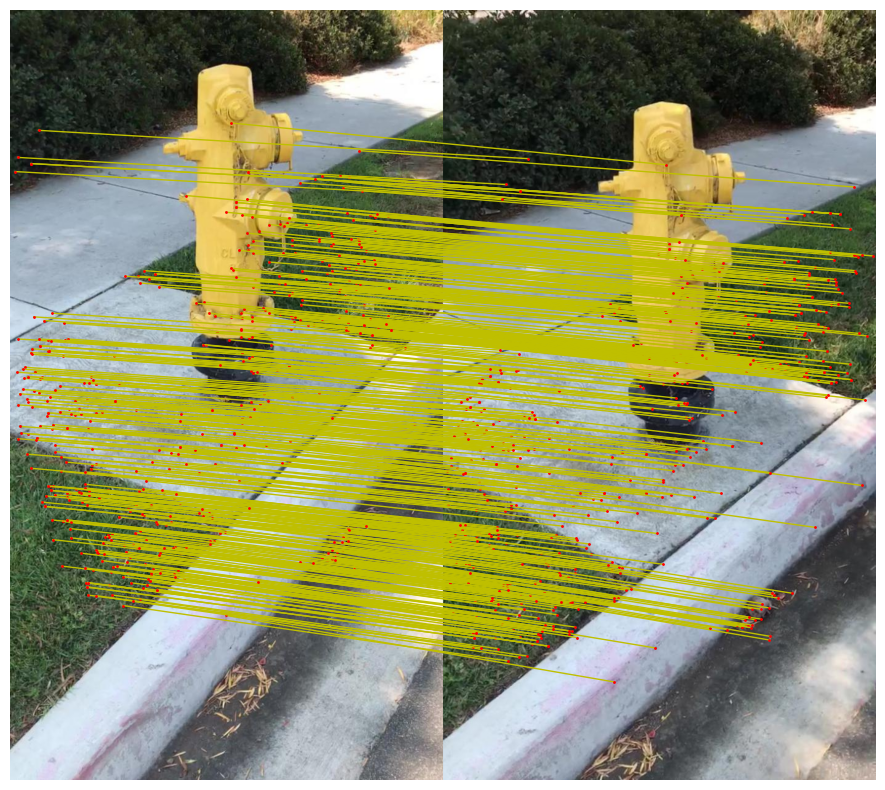

In [48]:
# File paths
image1_path = './project3/image1.jpg'
image2_path = './project3/image2.jpg'
npz_path = './project3/feature_points.npz'
intrinsics = np.load('./project3/intrinsics.npz')
K1 = intrinsics['K1']
K2 = intrinsics['K2']
# Load and display matches
img1, img2,pts1, pts2 = load_data(image1_path, image2_path,npz_path)

display_matches(img1, img2, pts1, pts2)

<img src = "https://drive.google.com/uc?export=view&id=1wD6L8Zl2FM75HLn8sy9ub-13ae4Jz0Hk">


# **Step 2: Fundamental Matrix Estimation and RANSAC** [15 points]
<img src="https://cmsc733.github.io/assets/2019/p3/ransac.png">

In [164]:
def estimate_Fmatrix(img1_pts, img2_pts):
    """
    Estimate the Fundamental Matrix using matched points from two images.

    Input:
        img1_pts: Matched points from Image 1 (numpy array of shape Nx2).
        img2_pts: Matched points from Image 2 (numpy array of shape Nx2).

    Output:
        F: Estimated Fundamental Matrix (3x3 numpy array).
    """
    pts1 = np.hstack((img1_pts, np.ones((img1_pts.shape[0], 1))))
    pts2 = np.hstack((img2_pts, np.ones((img2_pts.shape[0], 1))))
    
    x1, y1 = pts1[:, 0], pts1[:, 1]
    x2, y2 = pts2[:, 0], pts2[:, 1]

    A = np.column_stack([
        x1 * x2, y1 * x2, x2,
        x1 * y2, y1 * y2, y2,
        x1, y1, np.ones_like(x1)
    ])

    F = np.linalg.svd(A)[2][-1].reshape(3, 3)

    U, S, V = np.linalg.svd(F)
    S[2] = 0
    F = U @ np.diag(S) @ V

    return F

In [171]:
def ransac(pts1, pts2, iterations=1000000, threshold=0.05):
    """
    Apply RANSAC to estimate the Fundamental Matrix robustly.

    Input:
        pts1: Points from Image 1 (numpy array of shape Nx2).
        pts2: Points from Image 2 (numpy array of shape Nx2).
        iterations: Number of RANSAC iterations (int).
        threshold: Distance threshold

    Output:
        img1_inliers: Inliers from Image 1 (numpy array of shape Mx2).
        img2_inliers: Inliers from Image 2 (numpy array of shape Mx2).
        best_F: Best Fundamental Matrix found (3x3 numpy array).
    """
    best_mask = None
    best_inliers_len = 0
    best_F = None

    pts_length = pts1.shape[0]

    ones = np.ones((pts_length, 1))
    pts1_h = np.hstack([pts1, ones])
    pts2_h = np.hstack([pts2, ones])

    rand = np.random.randint(0, pts_length, size=(iterations, 8))

    for idx in rand:

        F = estimate_Fmatrix(pts1[idx], pts2[idx])

        errors = np.abs(np.sum(pts2_h @ F * pts1_h, axis=1))
        inlier_mask = errors < threshold
        inliers_count = np.sum(inlier_mask)

        if inliers_count > best_inliers_len:
            best_inliers_len = inliers_count
            best_mask = inlier_mask
            best_F = F

    return pts1[best_mask], pts2[best_mask], best_F

In [172]:
img1_points, img2_points, F = ransac(pts1, pts2)
print("Fundamental Matrix:", F)

Fundamental Matrix: [[ 1.15916676e-07 -1.93877396e-06 -1.63648001e-03]
 [ 3.24116734e-06  5.01865427e-07 -1.50672058e-02]
 [ 1.49063125e-03  1.43663147e-02  9.99780820e-01]]


# **Draw epipolar lines** [10 points]

In [169]:
def compute_epipolar_lines_manual(pts, F):
    """
    Compute epipolar lines for given points using the Fundamental Matrix.

    Input:
        pts: Points in homogeneous coordinates (numpy array of shape Nx2).
        F: Fundamental Matrix (3x3 numpy array).

    Output:
        lines: Epipolar lines in homogeneous form (Nx3 numpy array).

    Comments:
        - Converts points to homogeneous coordinates.
        - Computes lines using the Fundamental Matrix.
    """
    homogeneous = np.hstack((pts, np.ones((pts.shape[0], 1))))
    lines = np.dot(F, homogeneous.T).T
    return lines


# Function to draw epipolar lines on images
def draw_epipolar_lines_img1_points_img2_lines(img1, img2, pts1, F):
    """
    Draw epipolar lines on the second image for points from the first image.

    Input:
        img1: Image 1 in numpy array format.
        img2: Image 2 in numpy array format.
        pts1: Points in Image 1 (numpy array of shape Nx2).
        F: Fundamental Matrix (3x3 numpy array).
    """
    lines = compute_epipolar_lines_manual(pts1, F)

    img2_copy = img2.copy()
    for r in lines:
        a, b, c = r
        x0, y0 = map(int, [0, -c / b])
        x1, y1 = map(int, [img2.shape[1], -(c + a * img2.shape[1]) / b])
        img2_copy = cv2.line(img2_copy, (x0, y0), (x1, y1), (0, 255, 0), 1)

    plt.figure(figsize=(15, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(img2_copy, cv2.COLOR_BGR2RGB))

    plt.show()

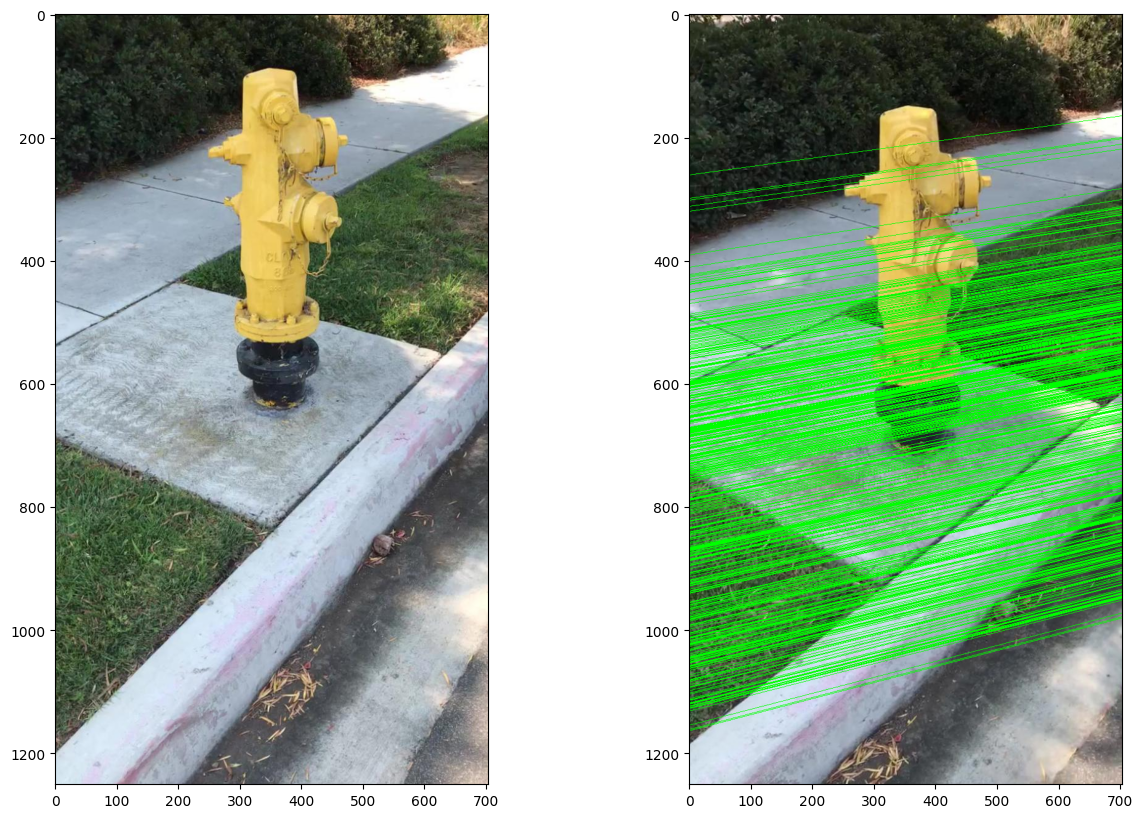

In [179]:
# Draw epipolar lines based on the fundamental matrix
draw_epipolar_lines_img1_points_img2_lines(img1, img2, img1_points, F)

# **Step 3: Estimate Essential Matrix E** [15 points]



In [102]:
def estimate_Essentialmatrix(K1, K2, F):
    """
    Estimate the Essential Matrix using camera intrinsics and the Fundamental Matrix.

    Input:
        K1: Intrinsic matrix of Camera 1 (3x3 numpy array).
        K2: Intrinsic matrix of Camera 2 (3x3 numpy array).
        F: Fundamental Matrix (3x3 numpy array).

    Output:
        E: Estimated Essential Matrix (3x3 numpy array).

    Comments:
        - Computes the Essential Matrix as E = K2.T * F * K
    """

    E = K2.T @ F @ K1

    # SVD
    U, S, Vt = np.linalg.svd(E)

    diag = np.array([[1, 0, 0],
                    [0, 1, 0],
                    [0, 0, 0]])


    E = U @ diag @ Vt

    # normalize
    # E = E / np.linalg.norm(E)

    return E

In [180]:
E = estimate_Essentialmatrix(K1, K2, F)
print("Essential Matrix E:",E )

Essential Matrix E: [[ 0.01025401 -0.1631526  -0.19634377]
 [ 0.2702041   0.03190662 -0.94351226]
 [ 0.23968497  0.95321456  0.0664429 ]]


# **Step 4: Extracting Poses form E matrix** [20 points]
<img src = "https://drive.google.com/uc?export=view&id=1vizqzdm0gB4sRWQSrvZZPjwezW2OG5tE">




In [104]:
def get_RTset(E):
    """
    Extract possible sets of rotation (R) and translation (T) from the Essential Matrix.

    Input:
        E: Essential Matrix (3x3 numpy array).

    Output:
        R: List of possible rotation matrices (4x 3x3 numpy arrays).
        T: List of possible translation vectors (4x 3x1 numpy arrays).

    Comments:
        - Uses SVD decomposition of the Essential Matrix.
        - Constructs four possible (R, T) pairs and ensures valid rotations
    """

    U, _, Vt = np.linalg.svd(E)

    if np.linalg.det(U) < 0:
        U = -U
    if np.linalg.det(Vt) < 0:
        Vt = -Vt

    W = np.array([[0, -1, 0],
                  [1,  0, 0],
                  [0,  0, 1]])

    # Initialize empty lists for poses
    R = []
    t = []

    t_raw = U[:, 2].reshape(3, 1)

    R1 = U @ W @ Vt
    if np.linalg.det(R1) < 0:
        R1 = -R1
        t1 = -t_raw
    else:
        t1 = t_raw
    R.append(R1)
    t.append(t1)

    # Second pair
    R.append(R1)
    t.append(-t1)

    # Third pair
    R3 = U @ W.T @ Vt
    if np.linalg.det(R3) < 0:
        R3 = -R3
        t3 = -t_raw
    else:
        t3 = t_raw
    R.append(R3)
    t.append(t3)

    # Fourth pair
    R.append(R3)
    t.append(-t3)

    return R, t


# **Step 5: Linear Triangulation** [15 points]


In [146]:
def linear_triangulation(R_Set, T_Set, pt1, pt2, k):
    """
    Perform linear triangulation to estimate 3D points.

    Input:
        R_Set: List of possible rotation matrices (4x 3x3 numpy arrays).
        T_Set: List of possible translation vectors (4x 3x1 numpy arrays).
        pt1: Points in Image 1 (numpy array of shape Nx2).
        pt2: Points in Image 2 (numpy array of shape Nx2).
        k: Camera intrinsic matrix (3x3 numpy array).

    Output:
        points_3d_set: List of 3D points for each (R, T) pair.

    Comments:
        - Triangulates 3D points for each (R, T) pair.
    """

    final_set = []

    for R, T in zip(R_Set, T_Set):

        # projection matrices
        P1 = k @ np.hstack((np.eye(3), np.zeros((3, 1))))
        P2 = k @ np.hstack((R, T.reshape(3, 1)))

        points_3d = []
        for p1, p2 in zip(pt1, pt2):
            # Ax = 0
            A = np.zeros((4, 4)) # def A
            A[0] = p1[0] * P1[2] - P1[0]
            A[1] = p1[1] * P1[2] - P1[1]
            A[2] = p2[0] * P2[2] - P2[0]
            A[3] = p2[1] * P2[2] - P2[1]

            # find x in Ax = 0
            _, _, V = np.linalg.svd(A)
            X = V[-1] # last column of V is our X
            X = X / X[-1]  # homogeneous coordinates
            points_3d.append(X[:3])

        final_set.append(np.array(points_3d))

    return final_set


# **Step 6: Cheriality condition** [20 points]

In [147]:
# Function to select the best pose (R, T) based on the chirality condition
def extract_pose(R_set, T_set, pts_3d_set):
    """
    Select the best pose (R, T) that satisfies the chirality condition.

    Input:
        R_set: List of possible rotation matrices (4x 3x3 numpy arrays).
        T_set: List of possible translation vectors (4x 3x1 numpy arrays).
        pts_3d_set: List of 3D point sets for each (R, T) pair.

    Output:
        R_best: Best rotation matrix (3x3 numpy array).
        T_best: Best translation vector (3x1 numpy array).
        X_best: Best 3D points (Nx3 numpy array).
        index: Index of the best (R, T) pair.

    """
    best_index = -1
    max_valid_points = -1
    R_best, T_best, X_best = None, None, None

    for i, (R, T, points_3d) in enumerate(zip(R_set, T_set, pts_3d_set)):

        camera_center = -R.T @ T
        row_three = R[2, :] # third row
        valid_points = compute_cheriality(points_3d, row_three, camera_center) # compute chirality
        if valid_points > max_valid_points:
            max_valid_points = valid_points
            best_index = i
            R_best = R
            T_best = T
            X_best = points_3d


    return R_best, T_best, X_best, best_index


In [148]:
def compute_cheriality(pt, r3, t):
    """
    Compute the chirality condition to determine if points are in front of the camera.

    Input:
        pt: 3D points (Nx3 numpy array). [x, y, z]
        r3: Third row of the rotation matrix (1x3 numpy array).
        t: Translation vector (3x1 numpy array).

    Output:
        count_depth: Number of points with positive depth.

    """
    camera_coordinate = pt - t.T
    depth = camera_coordinate @ r3.T
    count_depth = np.sum(depth > 0) # only want depth that is positive

    return count_depth


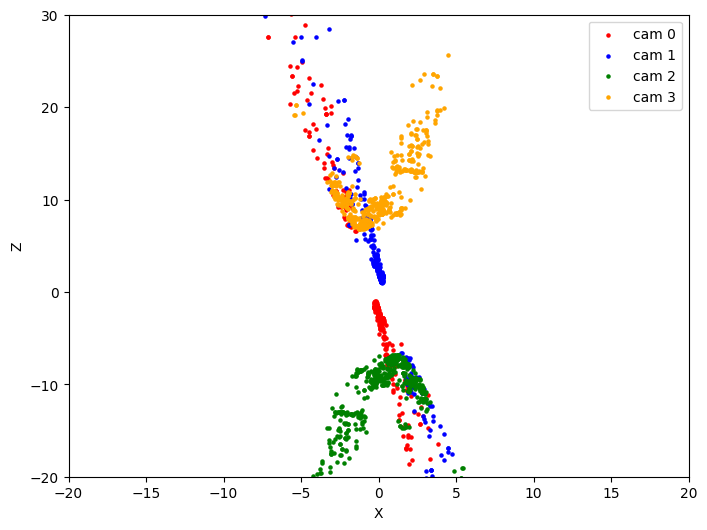

In [181]:
#Linear Triangulation
E = estimate_Essentialmatrix(K1, K2, F)
R_set, T_set = get_RTset(E)
point3D_set = linear_triangulation(R_set,T_set,img1_points,img2_points,K1)

#TO-DO: Plot all poses with 3D points as shown in figure

labels = [f"cam {i}" for i in range(len(point3D_set))]
colors = ['red', 'blue', 'green', 'orange']

plt.figure(figsize=(8, 6))

for i, points_3d in enumerate(point3D_set):
    points_3d = np.asarray(points_3d)

    x, z = points_3d[:, 0], points_3d[:, 2]
    plt.scatter(x, z, color=colors[i % len(colors)], label=labels[i], s=5)

plt.xlim(-20, 20)
plt.ylim(-20, 30)
plt.xlabel('X')
plt.ylabel('Z')
plt.legend()
plt.show()

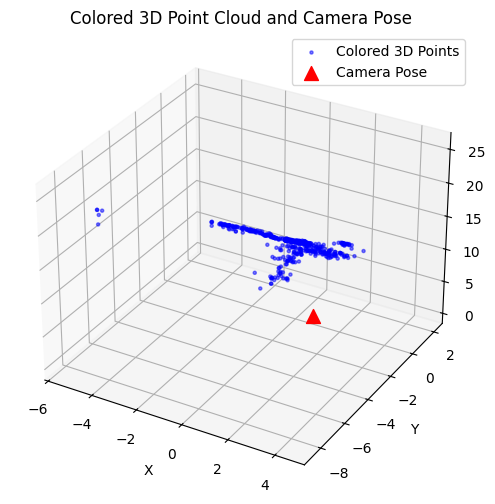

In [182]:
 #Get pose of camera using chirality condition
R_best, T_best,X_ ,index= extract_pose(R_set,T_set,point3D_set)
camera_label = "Camera Pose"

#TO-DO: Plot 3D point cloud with RGB color as shown in figure
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2],
            c='blue', s=5, label="Colored 3D Points", alpha=0.5)

camera_center = -np.dot(R_best.T, T_best).reshape(3)
ax.scatter(camera_center[0], camera_center[1], camera_center[2],
            c='red', marker='^', s=100, label=camera_label)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Colored 3D Point Cloud and Camera Pose")

ax.legend()
plt.show()

# **Extra Credit: Reconstruct Your Own Scene! (30 Points)**

For this part, you will run an off-the-shelf incremental SfM toolbox such as [COLMAP](https://github.com/colmap/pycolmap) on your own captured multi-view images. Please submit a GIF of the reconstructed 3D structure and the location of the cameras.

For this reconstruction, you can choose your own data. This data could either be a sequence with rigid objects (e.g., a mug or a vase from your vicinity) or any scene you wish to reconstruct in 3D.


Submission:

A gif to visualize the reconstruction of the scene and location of cameras.

https://drive.google.com/file/d/1nG5qLdHfZkjGt_dAW7OeB94ERnTuMy0b/view?usp=sharing


https://drive.google.com/file/d/1wPn_0Ko3rXHDj0WAYY3VvFdfonVygxJv/view?usp=sharing

## Report
You will be graded primarily based on your report.
A demonstration of understanding of the concepts involved in the project are required show the output produced by your code.

Include visualizations of the output of each stage in your pipeline (as shown in the system diagram on page 2), and a description of what you did for each step. Assume that we’re familiar with the project, so you don’t need to spend time repeating what’s already in the course notes. Instead, focus on any interesting problems you encountered and/or solutions you implemented.

# Submission Guidelines

**If your submission does not comply with the following guidelines, you’ll be given ZERO credit.**

Your submission on ELMS(Canvas) must be a pdf file, following the naming convention **YourDirectoryID_proj3.pdf**. For example, xyz123_proj3.pdf.

**All your results and report should be included in this notebook. After you finished all, please export the notebook as a pdf file and submit it to ELMS(Canvas).**

# Collaboration Policy
You are encouraged to discuss the ideas with your peers. However, the code should be your own, and should be the result of you exercising your own understanding of it. If you reference anyone else’s code in writing your project, you must properly cite it in your code (in comments) and your writeup. For the full honor code refer to the CMSC426 Fall 2023 website.

Project Inspiration Credit to CMSC733 COmputer Vision and 16-822: Geometry-based Methods in Vision
